# Modeling the COVID-19 Pandemic

## Reading

1. Bregman D.J., A.D. Langmuir, 1990. Farr's law applied to AIDS projections. _JAMA_, 263:1522–1525. doi: 10.1001/jama.263.11.1522. 

1. King, A.A.,  M.D. de Cellès, F.M.G. Magpantay, and P. Rohani, 2015. Avoidable errors in the modelling of outbreaks of emerging pathogens, with special reference to Ebola, _Proc. R. Soc. B._ 28220150347 http://doi.org/10.1098/rspb.2015.0347.

1. Murray, C.J.L., and IHME COVID-19 health service utilization forecasting team, 2020. Forecasting COVID-19 impact on hospital bed-days, ICU-days, ventilator-days and deaths by US state in the next 4 months,
https://www.medrxiv.org/content/10.1101/2020.03.27.20043752v1.full-text

1. Jewell, N.P.,  J.A. Lewnard,  and B.L. Jewell, 2020.
Predictive Mathematical Models of the COVID-19 Pandemic: Underlying Principles and Value of Projections,
_JAMA_, 323(19):1893-1894. doi:10.1001/jama.2020.6585

1. Froese, H., 2020. Infectious Disease Modelling: Fit Your Model to Coronavirus Data, Towards Data Science, https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7; https://github.com/henrifroese/infectious_disease_modelling 

1. Smith, D., and L. Moore, 2004. The SIR model for spread of disease, _Convergence_, https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-introduction



## Models of epidemics

This notebook explores two basic approaches to modeling the spread of a communicable disease through a population. There are more complicated approaches than are considered here, but these are common, and the predictions of COVID-19 infections and ICU beds are often based on variations of these models.

# SIR models

Mathematical models of epidemics date back to the early 1900s.

One of the simplest models of epidemics is the SIR model, which partitions the population into three disjoint groups: Susceptible, Infected, and Recovered (or Removed).

The SIR model treats the population as fixed: no births, immigration, emigration, or deaths from other causes.
It ignores the possibility of carriers, population heterogeneity, or geographic heterogeneity.
It treats everyone as equivalent and assumes the population "mixes" perfectly.

Here are the state variables of the SIR model:

+ $N$: initial population size
+ $S(t)$: number of susceptible individuals in the population at time $t$
+ $I(t)$: number of infected individuals in the population at time $t$
+ $R(t)$: number "removed" from risk (dead or recovered) in the population at time $t$

Assumptions:

+ Everyone is either susceptible, infected, or removed (recovered or dead). (There are more complex models with more "compartments.")
+ There are no births, immigration, emigration, or deaths from other causes.
+ If a susceptible person is infected, that person eventually dies or recovers. 
+ While a person is infected, the person is infectious.
+ There is no incubation period between being infected and being infectious.
+ If an infected person gets "close enough" to a susceptible person, the susceptible person becomes infected.
+ Every unit of time, every infected person exposes $\beta$ people.
+ Every susceptible person exposed to an infected person becomes infected.
+ Every infected person exposes a disjoint group of people.
+ Every unit of time, a fraction $\gamma$ of infected people recover or die.
+ People who recover or die are not infectious.
+ People who recover or die never become susceptible again.

Then $S + I + R = N$ is constant, the initial population size.

The basic reproductive number is $R_0 = \beta/\gamma$.
Initially, when essentially the entire population is susceptible (the proportion who are infected or recovered is small compared to $N$), this is the number of people each infected person infects before recovering or dying. 
(Note that $R_0$ has no connection to $R$: the notation is unfortunate.)

Define $s(t) \equiv S(t)/N$, $i(t) \equiv I(t)/N$, and $r(t) \equiv R(t)/N$.
Then $s+i+r = 1$ for all $t$.
There is an epidemic if $s(0)\beta/\gamma > 1$: the rate at which susceptible people are
getting infected is greater than the rate at which infected people are recoving. 

The parameters of the model are:

+ $\beta$, the number of exposed people per unit of time per infected persion
+ $\gamma$, the fraction of infected people who are removed (recover or die) per unit time

The state of the population evolves according to three coupled differential equations:

+ $dS/dt = -\beta I S/N$
+ $dI/dt = \beta I S/N - \gamma I$ (equivalently, $di/dt = \beta is - \gamma i$)
+ $dR/dt = \gamma I$

Another interesting variable is the cumulative number of infections, $C$.

+ $dC/dt = \beta I S/N$; $C(0) = I(0)$.

The SIR model has some built-in features that might not match reality.
First, note that the derivative of $R$ is always non-negative and proportional to $I$.
Since $R \le N$ and $N$ is finite, $I$ must eventually be zero; that is, the SIR implies that eventually
the entire population will be disease-free. 
Once $I=0$, it can never grow again, since the derivative of $I$ is proportional to $I$.
(If nobody is infected, nobody can infect anyone.)
Epidemics that follow the SIR model are necessarily self-limiting.

That isn't the case if immunity wears off over time (or if the population is not isolated).
In that case, we might we parametrize the transition from recovered to susceptible by 
assuming that a fraction $\delta$ of $R$ return to $S$ in each time period. 
(There are other ways we could do this, for instance, having a variable "lag" between recovery and becoming susceptible again.)
That yields:

+ $dS/dt = -\beta I S/N + \delta R$
+ $dI/dt = \beta I S/N - \gamma I$ (equivalently, $di/dt = \beta is - \gamma i$)
+ $dR/dt = \gamma I - \delta R$

In this model, $I$ does not necessarily go to zero eventually.

Other generalizations include separate "compartments" for dead versus recovered), needing an ICU bed, etc., as well as time-varying values of $\beta$ to account for lockdowns or other policy interventions, heterogeneity in the population, and more.

Let's run this model (in discrete time) for a population of $N=1,000,000$ people of whom 0.05% are initially infected.
We will take the time interval to be 1 day, the period of infectiousness to be $1/\gamma = 14$ days,
and $R_0 = 2 = \beta/\gamma$, so $\beta = 2 \gamma = 1/7$. We will start with $\delta=0$ (no re-infections).

In [1]:
# boilerplate
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML

In [2]:
def sir_model(N, i_0, beta=1, gamma=1, delta=0, steps=365):
    '''
    Run SIR model as coupled finite-difference equations.
    
    Assumes that initially a fraction i_0 of the population of N people is infected and 
    everyone else is susceptible (none has died or recovered).
    
    Parameters
    -----------
    N   :   int
        population size
    i_0 :   double in (0, 1)
        initial fraction of population infected
    beta :  double in [0, infty)
        number of encounters each infected person has per time step
    gamma : double in (0, 1)
        fraction of infecteds who recover or die per time step
    delta : double in (0, 1)
        fraction of recovereds who become susceptible per time step
    steps : int
        number of steps in time to run the model
    
    Returns
    --------
    S, I, R, C 
    S     : list
        time history of susceptibles
    I     : list
        time history of infecteds
    R     : list
        time history of recovered/dead    
    C.    : list
        cumulative number of infections over time
    '''
    assert i_0 > 0, 'initial rate of infection is zero'
    assert i_0 <= 1, 'infection rate greater than 1'
    assert beta >= 0, 'beta must be nonnegative'
    assert gamma > 0, 'gamma must be positive'
    assert gamma < 1, 'gamma must be less than 1'
    assert delta >= 0, 'delta must be nonnegative'
    assert delta < 1, 'delta must be less than 1'
    S = np.zeros(steps)
    I = np.zeros(steps)
    R = np.zeros(steps)
    C = np.zeros(steps)
    I[0] = int(N*i_0)
    C[0] = I[0]
    S[0] = N-I[0]
    for i in range(steps-1):
        new_i = beta*I[i]*S[i]/N
        S[i+1] = max(0, S[i] - new_i + delta*R[i])
        I[i+1] = max(0, I[i] + new_i - gamma*I[i])
        R[i+1] = max(0, R[i] + gamma*I[i] - delta*R[i])
        C[i+1] = C[i] + new_i
    return S, I, R, C

In [3]:
def plot_sir(N, i_0, beta=2/14, gamma=1/14, delta=0, steps=365, verbose=False):
    '''
    Plot the time history of an SIR model.
    
    Parameters
    -----------
    N     : int
        population size
    i_0   : double in (0, 1)
        infection rate at time 0
    beta  :  double in [0, infty)
        number of encounters each infected person has per time step
    gamma : double in (0, 1)
        fraction of infecteds who recover or die per time step
    delta : double in (0, 1)
        fraction of recovereds who become susceptible per time step
    steps : int
        number of time steps to run the model
    verbose : Boolean
        if True, return the model predictions
    
    Returns (if verbose == True)
    --------
    S : list
        susceptibles as a function of time
    I : list
        infecteds as a function of time
    R : list
        recovereds as a function of time
    C : list
        cumulative incidence as a function of time
    '''
    S, I, R, C = sir_model(N, i_0, beta=beta, gamma=gamma, delta=delta, steps=steps)
    times = list(range(steps))
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(times, I, linestyle='--', color='r', label='Infected')
    ax.plot(times, S, linestyle='-', color='b', label='Susceptible')
    ax.plot(times, R, linestyle=':', color='g', label='Recovered')
    ax.plot(times, C, linestyle='-.', color='k', label='Tot infect.')
    ax.legend(loc='best')
    plt.show()
    if verbose:
        return S, I, R, C

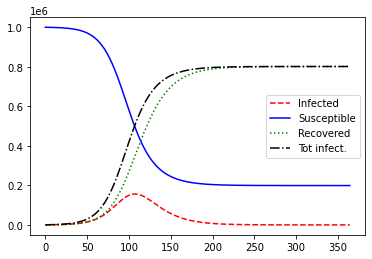

In [4]:
i_0 = 0.0005
N = int(10**6)
steps = 365

plot_sir(N, i_0)

For these parameters, the number of infections is shaped like a bell curve and the cumulative number of infections is shaped like a CDF: it is "sigmoidal" (vaguely "S"-shaped). You might imagine fitting a scaled CDF to the curve. Essentially, the IHME model fits a scaled Gaussian CDF to the total number of infections.
(More on this below.)

What if immunity wears off over time? Let's try a positive value of $\delta$:

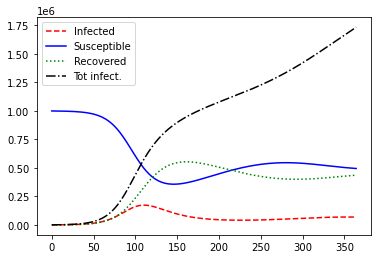

In [5]:
plot_sir(N, i_0, delta=0.01)

In [6]:
interact(plot_sir, N=fixed(N),
                   i_0 = widgets.FloatSlider(min=0, max=1, value=i_0),
                   beta=widgets.FloatSlider(value=2/14, min=0.01, max=100),
                   gamma=widgets.FloatSlider(value=1/14, min=0, max=1, step=0.01),
                   delta=widgets.FloatSlider(value=0, min=0, max=1, step=0.01),
                   steps=fixed(steps),
                   verbose=fixed(False))

interactive(children=(FloatSlider(value=0.0005, description='i_0', max=1.0), FloatSlider(value=0.1428571428571…

<function __main__.plot_sir(N, i_0, beta=0.14285714285714285, gamma=0.07142857142857142, delta=0, steps=365, verbose=False)>

## Fitting the SIR model to data

Now we will use least squares to fit the SIR model to a time history of infection data collected by researchers at Johns Hopkins University.See https://github.com/CSSEGISandData


This exercise is for illustration. There are many reasons to be wary of this modeling:

+ There are serious issues with the data quality: these are cases that were _reported_ according to the rules and circumstances of where they were detected. For mortality (rather than incidence), excess mortality might give a more accurate measure.
+ The model is a cartoon, not "physics" of epidemics, and it omits many factors that plausibly matter. It is not clear what estimates of the parameters mean when the model is wrong.
+ Absent a trustworthy generative model for the data, it is not clear how to assess or interpret the uncertainty of the estimates.
+ If the estimated model is to be used for prediction, there is no obvious way to assign meaningful uncertainties to the predictions.
+ The optimization problem to fit the parameters has no statistical content or motivation. It is not clear that it yields an estimate that is "good" in a useful sense. 
+ The objective function is not convex in the model parameters, and the optimization algorithm is not guaranteed to solve the optimization problem.

The data record total "confirmed" cases as a function of time, deaths, and recoveries: $C(t)$

In [7]:
from scipy.optimize import curve_fit  # nonlinear least squares

def f(x, beta, gamma):
    '''
    Model cumulative infections
    
    This is just a wrapper for a call to sir_model, to generate a set of
    predictions of the cumulative incidence for curve fitting
    '''    
    return sir_model(N, i_0, beta, gamma, delta=0, steps=len(x))[3]  # C

In [8]:
# test f
N = int(10**6)
i_0 = 0.0005
x = range(25)
y = f(x, 1/7, 1/14 )
y

array([ 500.        ,  571.39285714,  647.87464122,  729.80689646,
        817.5766761 ,  911.59831599, 1012.31532767, 1120.20241833,
       1235.76764552, 1359.55471484, 1492.14542917, 1634.1622985 ,
       1786.27131969, 1949.18493587, 2123.66518564, 2310.5270524 ,
       2510.64202461, 2724.94187786, 2954.42268994, 3200.14910031,
       3463.25882519, 3744.96743963, 4046.57343789, 4369.46358264,
       4715.11855381])

In [9]:
# test curve_fit
popt, pvoc = curve_fit(f, x, y, p0=[1, 0.5], bounds = (0, [np.inf, 1]))
popt

array([0.14285714, 0.07142857])

In [10]:
# try some real data from the JHU site
import pandas as pd
# data for countries. THIS IS A "LIVE" DATASET THAT IS UPDATED FREQUENTLY
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url, sep=",")

In [11]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,55008,55023,55059,55121,55174,55231,55265,55330,55335,55359
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,77251,78127,78992,79934,80941,81993,83082,84212,85336,86289
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,107122,107339,107578,107841,108116,108381,108629,108629,109088,109313
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,9885,9937,9972,10017,10070,10137,10172,10206,10251,10275
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,19782,19796,19829,19900,19937,19996,20030,20062,20086,20112


In [12]:
# data for Denmark
DK = df.loc[(df["Country/Region"] == "Denmark") & df["Province/State"].isna()]  # Denmark
DK = DK.drop(['Province/State','Country/Region','Lat','Long'], axis=1).T        # remove fields we don't need
y = DK.to_numpy()   # turn series into a vector
y = y[np.nonzero(y)] # remove the data before the first detected case
x = range(len(y))    # for model-fitting and plotting
print(len(y),y)

348 [     1      1      3      4      4      6     10     10     23     23
     35     90    262    442    615    801    827    864    914    977
   1057   1151   1255   1326   1395   1450   1591   1724   1877   2046
   2201   2395   2577   2860   3107   3386   3757   4077   4369   4681
   5071   5402   5635   5819   5996   6174   6318   6511   6681   6879
   7073   7242   7384   7515   7695   7912   8073   8210   8445   8575
   8698   8851   9008   9158   9311   9407   9523   9670   9821   9938
  10083  10218  10319  10429  10513  10591  10667  10713  10791  10858
  10927  10968  11044  11117  11182  11230  11289  11360  11387  11428
  11480  11512  11593  11633  11669  11699  11734  11771  11811  11875
  11924  11948  11962  12001  12016  12035  12099  12139  12193  12217
  12250  12294  12344  12391  12391  12391  12527  12561  12615  12636
  12675  12675  12675  12751  12768  12794  12815  12832  12832  12832
  12878  12888  12900  12916  12946  12946  12946  13037  13061  13092
  

Text(0.5, 0, 'Days since first detected case')

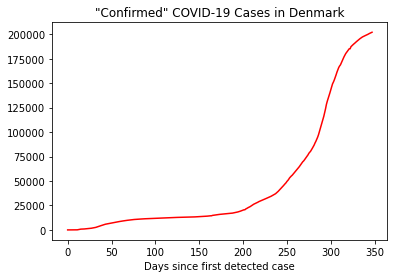

In [13]:
plt.plot(x,y, linestyle='-', color='r')
plt.title('"Confirmed" COVID-19 Cases in Denmark')
plt.xlabel('Days since first detected case')

In [14]:
N = 5792202 # estimated population of DK in 2020
i_0 = y[0]/N # initial prevalence
x = np.array(range(len(y)))

In [15]:
# fit the model by nonlinear least squares
popt, pvoc = curve_fit(f, x, y, p0=[1, 0.5], bounds = (0, [500, 1]), maxfev=10000)
popt

array([1.02945792, 1.        ])

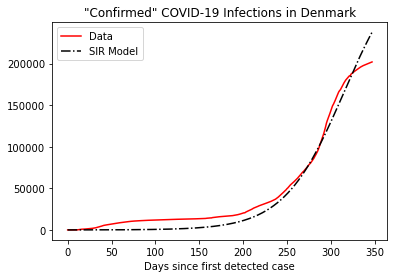

In [16]:
S, I, R, C = sir_model(N, i_0, beta=popt[0], gamma=popt[1], delta=0, steps=len(y))
times = list(range(len(y)))
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, y, linestyle='-', color='r', label='Data')
ax.plot(times, C, linestyle='-.', color='k', label='SIR Model')
ax.legend(loc='best')
plt.xlabel('Days since first detected case')
plt.title('"Confirmed" COVID-19 Infections in Denmark')
plt.show()

What happens if we run the model into the future?

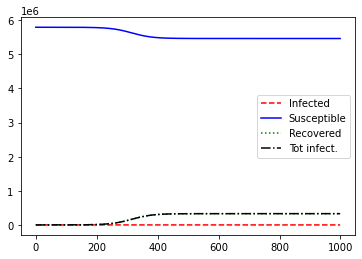

In [17]:
S, I, R, C = plot_sir(N, i_0, beta=popt[0], gamma=popt[1], delta=0, steps=1000, verbose=True)

The total number of infections stabilizes, and the pandemic abates. The effective reproductive number $R_0$ is less than 1.

Let's do a quick sanity check.
Recall that $R_0 = \beta/\gamma$ for the SIR model _initially_, when the number infected, recovered, or dead are negligible compared to the total population.
Once some of the population has recovered, some of the people an infectious person encounters wiil be people who have recovered and not susceptible to reinfection (according to the model).
To first order, $\beta$ is effectively reduced by $S/N$.

In [18]:
# R_0 at the time the first infection is detected
popt[0]/popt[1] # greater than 1. According to the model, the infection will spread if R_0 > 1.

1.0294579200337055

In [19]:
# After 1000 timesteps, R_0 is different 
(S[-1]/N)*popt[0]/popt[1] # less than 1: According to the model, the infection will abate.

0.9708226266749372

# Fitting curves to the cumulative incidence function 

The SIR model and its variants attempt to capture the dynamics of transmission and recovery,
For some parameter choices, that leads to a sigmoidal shape for the cumulative incidence of infections.

Some pandemic predictions simply fit a sigmoidal function to the cumulative number of infections, an approach
that dates back to William Farr in the 1800s. 
King et al. (2015) showed that this approach does not work well for AIDS or Ebola.
Nonetheless, this is the approach the IHME takes: they fit a scaled and shifted Gaussian cdf to 
cumulative incidence.



## Sigmoidal Models


Common sigmoidal models include CDFs of unimodal distributions (such as the Gaussian) and the sigmoid function $1/(\exp(-x) + 1)$, the inverse of the logistic function.

To allow this function to be shifted and scaled, we can introduce the family of curves

\begin{equation}
\sigma(x; a, b, c) \equiv c \frac{1}{e^{-b(x-a)}+1}.
\end{equation}

The parameter $a$ controls where the function crosses $c/2$; $b$ controls how rapidly it increases, and $c$ is its asymptotic limit.

Let's fit this to the Danish data.

In [20]:
def g(x, a, b, c):
    '''
    Model cumulative infections using a sigmoid
    '''    
    return c/(np.exp(-b*(x-a))+1)

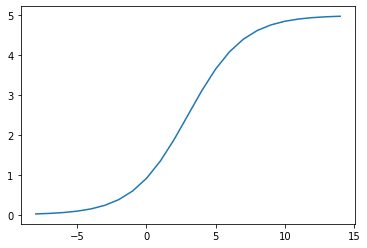

In [21]:
# test g visually.
z = np.array(range(-8,15,1))
plt.plot(z, g(z,3,1/2,5))

In [22]:
# fit the DK data
popts, pvocs = curve_fit(g, x, y, p0=[len(x)/2, 0.02, np.max(y)/2], bounds = ([0, 0, 0], [500, 500, N]), maxfev=10000)
popts

array([3.13414705e+02, 2.46283393e-02, 3.17721793e+05])

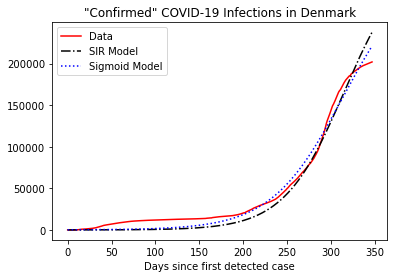

In [23]:
# plot
Cs = g(x, popts[0], popts[1], popts[2])
times = list(range(len(y)))
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, y, linestyle='-', color='r', label='Data')
ax.plot(times, C[:len(times)], linestyle='-.', color='k', label='SIR Model')
ax.plot(times, Cs, linestyle=':', color='b', label='Sigmoid Model')
ax.legend(loc='best')
plt.xlabel('Days since first detected case')
plt.title('"Confirmed" COVID-19 Infections in Denmark')
plt.show()

Both models agree reasonably well with past data. But they have rather different predictions about the future.

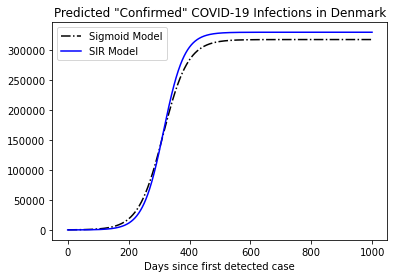

In [24]:
# what does this model predict for the future?
times = np.array(range(1000))
Cs = g(times, popts[0], popts[1], popts[2])
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, Cs, linestyle='-.', color='k', label='Sigmoid Model')
ax.plot(times, C, linestyle='-', color='b', label='SIR Model')
ax.legend(loc='best')
plt.xlabel('Days since first detected case')
plt.title('Predicted "Confirmed" COVID-19 Infections in Denmark')
plt.show()

Let's look at how the predictions vary over time, as the dataset grows.

In [25]:
def plot_predictions(y, n, points=1000):
    '''
    plot predictions of the SIR and sigmoid models based on the first n data
    
    Parameters
    ----------
    y : list of floats
        number of infections at each time in x
    points : int
        number of time points for which to plot the prediction
        
    Returns
    -------
    no return value
    '''
    # fit the two models
    x = list(range(len(y)))
    popt, pvoc = curve_fit(f, x[:n], y[:n], p0=[1, 0.5], bounds = (0, [500, 1]),
                           maxfev=10000)
    popts, pvocs = curve_fit(g, x[:n], y[:n], p0=[len(x)/2, 0.02, np.max(y)/2],
                             bounds = ([0, 0, 0], [500, 500, N]), maxfev=10000)
    times = list(range(points))
    S, I, R, C = sir_model(N, i_0, beta=popt[0], gamma=popt[1], delta=0, steps=points)
    Cs = g(times, popts[0], popts[1], popts[2])
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(x, y, linestyle='-', color='r', label='Data')
    ax.plot(times, C, linestyle='-.', color='k', label='SIR Model')
    ax.plot(times, Cs, linestyle=':', color='b', label='Sigmoid Model')
    ax.vlines(x[n-1], 0, np.max([C, Cs]), label='truncation time')
    ax.legend(loc='best')
    plt.xlabel('Days since first detected case')
    plt.title('"Confirmed" COVID-19 Infections in Denmark')
    plt.show()

In [26]:
interact(plot_predictions, y=fixed(y),
                   n = widgets.IntSlider(min=20, max=len(y), value=100),
                   points=fixed(1000))

interactive(children=(IntSlider(value=100, description='n', max=348, min=20), Output()), _dom_classes=('widget…

<function __main__.plot_predictions(y, n, points=1000)>

The predictions depend on the model and details of the data. Including a week more or a week less can drastically change the predictions. For some datasets, the two models have nearly identical predictions; for others, they can differ by a factor of 20 or more.

This is not a reliable basis for predicting the course of the pandemic, predicting ICU demand, predicting the effect of an intervention, allocating resources, or setting public policy.
It is a mechanical application of models and algorithms to data: mindless curve-fitting.

Unsurprisingly, models of this type do not predict infections well in practice. 
The [most-cited predictions](https://covid19.healthdata.org/global?view=total-deaths&tab=trend) have been those promulgated by the [Institute for Health Metrics and Evaluation](http://www.healthdata.org/) (IHME) at the University of Washington.
They say, 

>Our model is designed to be a planning tool for government officials who need to know how different policy decisions can radically alter the trajectory of COVID-19 for better or worse.

>Our model aimed at helping hospital administrators and government officials understand when demand on health system resources will be greatest. (http://www.healthdata.org/covid/faqs#differences%20in%20modeling, last visited 23 January 2021)

IHME's model is described [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-020-1132-9/MediaObjects/41591_2020_1132_MOESM1_ESM.pdf).
Early in the pandemic, IHME predicted that there would be about 60,000 COVID-19 deaths in ths U.S.
As of January 23, 2021, there have been about 414,000. 
Between March and August, 2020, next-day deaths were within the IHME 95% prediction interval only about 
30% of the time, despite revisions of the model https://arxiv.org/abs/2004.04734.
(We shall not delve into how IHME produces its prediction intervals.)
See also https://www.vox.com/future-perfect/2020/5/2/21241261/coronavirus-modeling-us-deaths-ihme-pandemic.

One feature of the sigmoidal models is that they predict rapid declines after the peak, a feature that
some politicians like. 
That feature is built into the sigmoidal curve: it is an _assumption_, not something that comes from the data.

There are also more complicated models of pandemics, including models with more "compartments," models based on other sigmoidal functions (such as the Gaussian CDF), and models that allow various kinds of heterogeneity within the population and simulate interactions between individuals.
Some have proved more accurate than others.
Just how poorly some models perform is obscured by the practice of revising the model and projections frequently--even daily. 

Sometimes, a moddle with little substantive foundation can nonetheless predict the behavior of a system, at least if the system is not changing quickly. 
Accurate predictions of the effect of interventions (masks, lockdowns, vaccination, and so on) require a close tie between the world and the model: the model needs a substantive basis. 
For causal inferences, the model needs to be a _generative model_ or _response schedule_.

George Box famously wrote, "all models are wrong, but some are useful."
The questions are:

* useful for what?
* how can you tell whether a model is useful for a particular goal?

In the same paper, Box wrote, "It is inappropriate to be concerned with mice when there are tigers abroad."
Most of the fretting people do about statistical models is at the level of mice (e.g., asymptotics under unrealistic assumptions), while the problems with most 
statistical models are tigers: the models have little or no basis in the actual scientific question.

## New variants

As of this writing (9 February 2021), new strains of COVID-19 have been detected in the UK, South Africa, and the US, where cases of the new strain have a doubling time of about 10 days. The UK strain is estimated to be 50% to 70% more transmissible than the original virus. There is mounting evidence that the strain is also more lethal.
https://www.wsj.com/articles/new-u-k-covid-19-variant-could-be-more-deadly-british-officials-say-11611338370 (last visited 22 January 2021).
